# Time complexity CCD

This file is to determine the time complexity dependent on the number of joint from the robot arm

In [2]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
def sample_targets(num_targets):
    radius = np.random.uniform(0, 1, num_targets)
    theta = np.random.uniform(0, 2 * np.pi, num_targets)

    coords = np.zeros((num_targets, 3))
    coords[:, 0] = radius * np.cos(theta)
    coords[:, 1] = radius * np.sin(theta)

    return coords

In [4]:
def rotateZ(theta):
    rz = np.array(
        [
            [math.cos(theta), -math.sin(theta), 0, 0],
            [math.sin(theta), math.cos(theta), 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ]
    )
    return rz


def translate(dx, dy, dz):
    t = np.array([[1, 0, 0, dx], [0, 1, 0, dy], [0, 0, 1, dz], [0, 0, 0, 1]])
    return t


# Forward Kinematics
# Input initial angles and length of links
# Output positions each points
def FK(angle, link):
    n_links = len(link)
    P = []
    P.append(np.eye(4))
    for i in range(0, n_links):
        R = rotateZ(angle[i] / 180 * math.pi)
        T = translate(link[i], 0, 0)
        P.append(P[-1].dot(R).dot(T))
    return P


def IK(target, angle, link, max_iter=10000, err_min=0.1):
    solved = False
    err_end_to_target = math.inf

    for loop in range(max_iter):
        for i in range(len(link) - 1, -1, -1):
            P = FK(angle, link)
            end_to_target = target - P[-1][:3, 3]
            err_end_to_target = math.sqrt(end_to_target[0] ** 2 + end_to_target[1] ** 2)
            if err_end_to_target < err_min:
                solved = True
            else:
                # Calculate distance between i-joint position to end effector position
                # P[i] is position of current joint
                # P[-1] is position of end effector
                cur_to_end = P[-1][:3, 3] - P[i][:3, 3]
                cur_to_end_mag = math.sqrt(cur_to_end[0] ** 2 + cur_to_end[1] ** 2)
                cur_to_target = target - P[i][:3, 3]
                cur_to_target_mag = math.sqrt(
                    cur_to_target[0] ** 2 + cur_to_target[1] ** 2
                )

                end_target_mag = cur_to_end_mag * cur_to_target_mag

                if end_target_mag <= 0.0001:
                    cos_rot_ang = 1
                    sin_rot_ang = 0
                else:
                    cos_rot_ang = (
                        cur_to_end[0] * cur_to_target[0]
                        + cur_to_end[1] * cur_to_target[1]
                    ) / end_target_mag
                    sin_rot_ang = (
                        cur_to_end[0] * cur_to_target[1]
                        - cur_to_end[1] * cur_to_target[0]
                    ) / end_target_mag

                rot_ang = math.acos(max(-1, min(1, cos_rot_ang)))

                if sin_rot_ang < 0.0:
                    rot_ang = -rot_ang

                # Update current joint angle values
                angle[i] = angle[i] + (rot_ang * 180 / math.pi)

                if angle[i] >= 360:
                    angle[i] = angle[i] - 360
                if angle[i] < 0:
                    angle[i] = 360 + angle[i]

        if solved:
            break

    return angle, err_end_to_target, solved, loop

In [5]:
num_targets = 1000

# sample targets returns only with radius between 0 and 1
# therefore multiply targets with number of joints
n_joints = np.linspace(2, 22, 11, dtype=int)
results = np.zeros((len(n_joints), num_targets))

In [5]:
for joint_idx, n_joint in enumerate(n_joints):
    targets = sample_targets(num_targets) * n_joint
    link = np.ones(n_joint)
    start_angles = np.zeros(n_joint)

    for target_idx, target in enumerate(targets):
        angles, error, _, loop = IK(target, start_angles, link)
        results[joint_idx, target_idx] = loop

    print(
        "joints: ",
        n_joint,
        " num_steps: ",
        results[joint_idx].mean(),
        " std: ",
        results[joint_idx].std(),
    )

df = pd.DataFrame(results)
df.to_csv("./ccd_time_complexity.csv")

joints:  2  num_steps:  2.313  std:  2.480127214479128
joints:  4  num_steps:  7.61  std:  12.596821027545007


KeyboardInterrupt: 

(11, 1000)
[  2.562   7.148  16.144  27.125  36.411  48.031  75.949  94.057 104.616
 107.845 154.503]


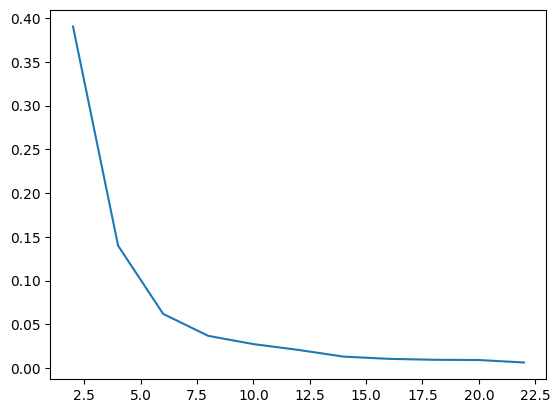

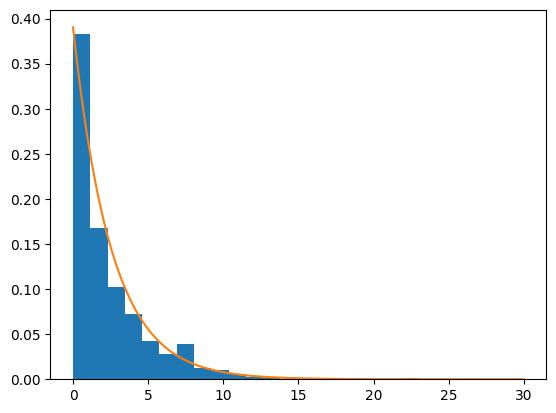

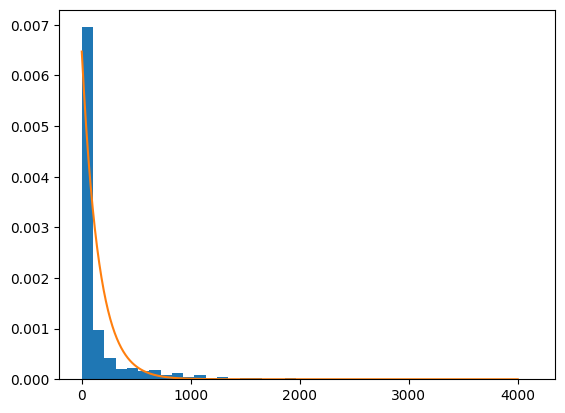

In [19]:
df = pd.read_csv("./ccd_time_complexity.csv")
results = np.array(df)[:, 1:]
print(results.shape)
means = results.mean(axis=1)
print(means)
# because the distribution  is similar to an exponential distribution we want to derive the lambda parameter
# E[X] = 1 / lambda  <=> lambda = 1 / E[X]
lmbd = 1 / means
var = 1 / lmbd**2

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(n_joints, lmbd)

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(results[0], bins=20, density=True)
x = np.linspace(0, 30, 200)
y = lmbd[0] * np.exp(-lmbd[0] * x)
ax.plot(x, y)

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(results[-1], bins=40, density=True)
x = np.linspace(0, 4000, 200)
y = lmbd[-1] * np.exp(-lmbd[-1] * x)
ax.plot(x, y)

# plt.errorbar(num_joints, means, var)
# plt.hist(results[0], 50)

# TODO: make 3 dimensional plt horizontal axis = num joints, vertical axis = runtime, color map = buckets from historgrams
# run_times = []
# for idx in range(len(results)):
#     bin_nums, bins, fig = plt.hist(results[-(idx + 1)], 5000)

array([8, 9])